## Yield curve prediction

The goal of this case study is to use supervised learning-based models to predict the yield
curve. This case study is inspired by the paper “_Artificial Neural Networks in Fixed Income Markets for Yield Curve Forecasting_” by Nunes, Gerding, McGroarty and Niranj

## Content

* [1. Introduction](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Exploratory Data Analysis](#2)
    * [3.1 Descriptive Statistics](#2.1)    
    * [3.2. Data Visualisation](#2.2)
* [4. Data Preparation and analysis](#3)
    * [4.1.Feature Selection](#3.1)
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split and Evaluation metrics](#4.1)]]
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)
* [7. Finalize the Model](#6)  
    * [7.1. Results and comparison of Regression and MLP](#6.1)

<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, three tenors (i.e. 1M,
5Y and 30Y) of the yield curve are the predicted variable. These tenors represent short
term, medium term and long-term tenors of the yield curve.

### Features

In order to make predictions, we use the following features: 


    1. Previous Changes in the Treasury Curve at the following tenors: 1 Month, 3 Month, 1 Year, 2 Year, 5 Year, 7 Year, 10 Year, 30 Year
        
    2. Changes in % of Federal Debt held by -
    
        a. Public,       
        b. Foreign Goverments        
        c. Federal Reserve
        
    3. The Coporate Spread on Baa rated Debt Relative to the 10 Year

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

### Feature Variables

In [1]:
import os
import sys


root_dir = os.path.abspath('../..')
sys.path.append(root_dir)
from functions import ParamsKfold, ParamsGridSearch, run_grid_search, run_kfold_analysis

# Core libraries
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import seaborn as sns
from matplotlib import pyplot
from pandas.plotting import scatter_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

# Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

# Libraries for Statistical Models
import statsmodels.api as sm

# Libraries for Saving the Model
from pickle import dump, load

# Time series Models
from statsmodels.tsa.arima.model import ARIMA
# from statsmodels.tsa import SARIMAX

# Error Metrics
from sklearn.metrics import mean_squared_error, r2_score

# Feature Selection
from sklearn.feature_selection import chi2, f_regression, SelectKBest

# Plotting 
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf


2022-10-01 08:37:35.303061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-01 08:37:35.303294: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Disable the warnings

import warnings
warnings.filterwarnings('ignore')


<a id='1.2'></a>
## 2.2. Loading the Data

In [3]:
# Get the data by webscapping using pandas datareader

tsy_tickers = [
    'DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
    'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
    'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
    'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
    'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
    'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
]
tsy_data = web.DataReader(tsy_tickers, 'fred').dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOV_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOM_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOR_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']


In [4]:
return_period = 5

y = tsy_data.loc[:, ['DGS1MO', 'DGS5', 'DGS30']].shift(-return_period)
y.columns = [col + '_pred' for col in y.columns]
x = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOV_PCT', 'HOM_PCT', 'FOR_PCT', 'BAA10Y']]

dataset = pd.concat([y, x], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, y.columns]
X = dataset.loc[:, x.columns]


In [5]:
dataset.head(2)

,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2018-01-01,1.30,2.29,2.81,1.28,1.39,1.76,1.89,2.20,2.33,2.40,2.74,0.116371,0.73196,0.295093,1.77
2018-01-08,1.33,2.36,2.83,1.30,1.45,1.79,1.96,2.29,2.41,2.49,2.81,0.116086,0.73196,0.295093,1.74


<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
dataset.shape


(239, 15)

In [7]:
pd.set_option('precision', 3)
dataset.describe()


,DGS1MO_pred,DGS5_pred,DGS30_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOV_PCT,HOM_PCT,FOR_PCT,BAA10Y
count,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000,239.000
mean,1.075,1.701,2.407,1.069,1.152,1.355,1.468,1.693,1.851,1.966,2.403,0.141,0.760,0.275,2.183
std,0.970,0.993,0.640,0.964,0.994,1.090,1.094,0.981,0.899,0.824,0.635,0.038,0.023,0.021,0.407
min,0.000,0.190,1.170,0.000,0.000,0.040,0.110,0.190,0.360,0.520,1.170,0.091,0.731,0.243,1.590
25%,0.080,0.795,1.925,0.080,0.090,0.135,0.210,0.795,1.120,1.350,1.925,0.103,0.736,0.255,1.910
50%,1.300,1.650,2.310,1.280,1.450,1.580,1.580,1.650,1.740,1.810,2.310,0.152,0.776,0.266,2.130
75%,2.000,2.675,3.020,1.985,2.045,2.330,2.500,2.660,2.760,2.800,3.020,0.183,0.783,0.295,2.295
max,2.730,4.150,3.720,2.620,3.370,4.050,3.950,3.690,3.620,3.490,3.530,0.191,0.786,0.305,4.040


<a id='2.2'></a>
## 3.2. Data Visualization

<AxesSubplot:xlabel='DATE'>

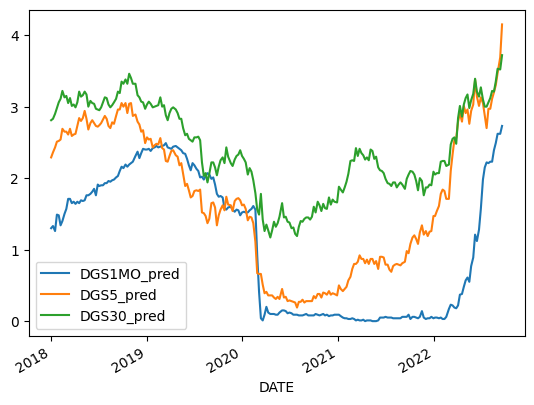

In [8]:
Y.plot()


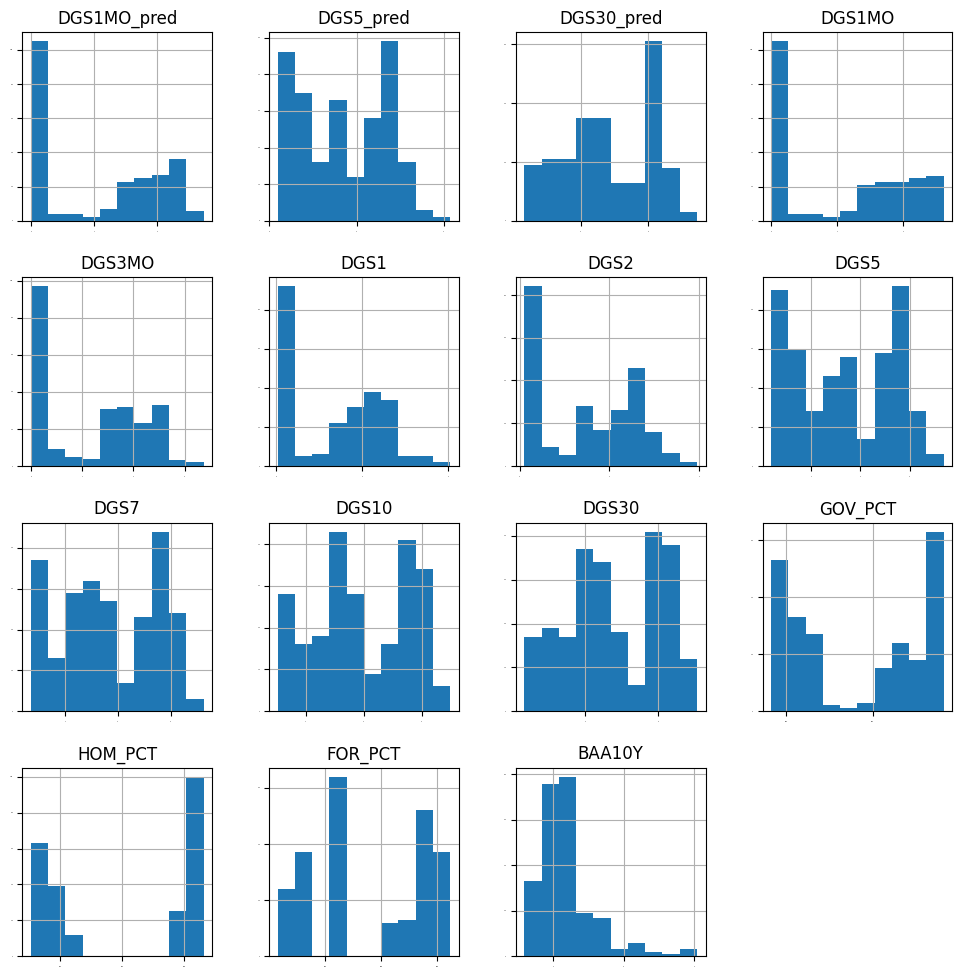

In [9]:
# Histograms

dataset.hist(
    sharex=False, 
    sharey=False, 
    xlabelsize=1, 
    ylabelsize=1, 
    figsize=(12, 12)
)
pyplot.show()


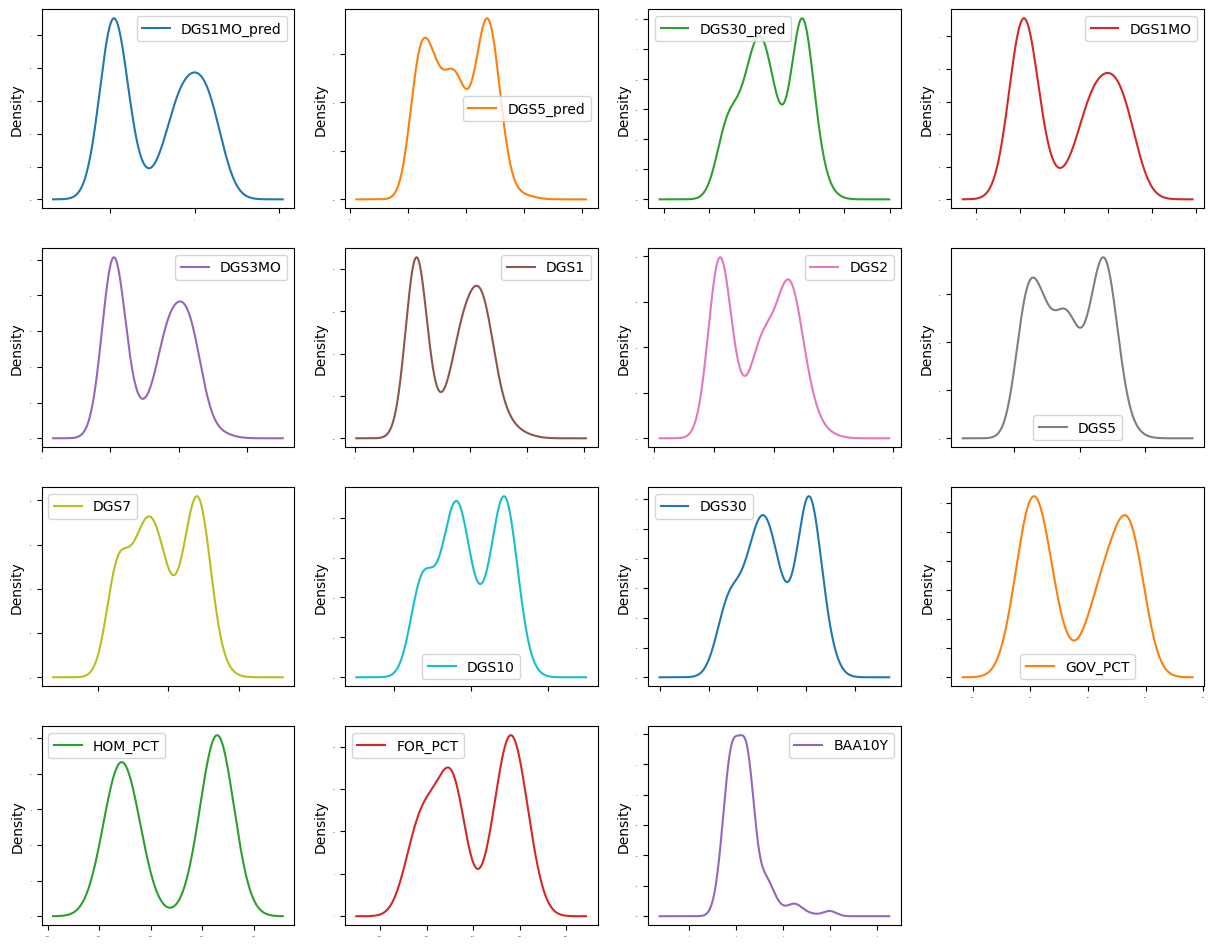

In [10]:
# Density

dataset.plot(
    kind='density', 
    subplots=True, 
    layout=(5, 4), 
    sharex=False, 
    legend=True, 
    fontsize=1, 
    figsize=(15, 15)
)
pyplot.show()


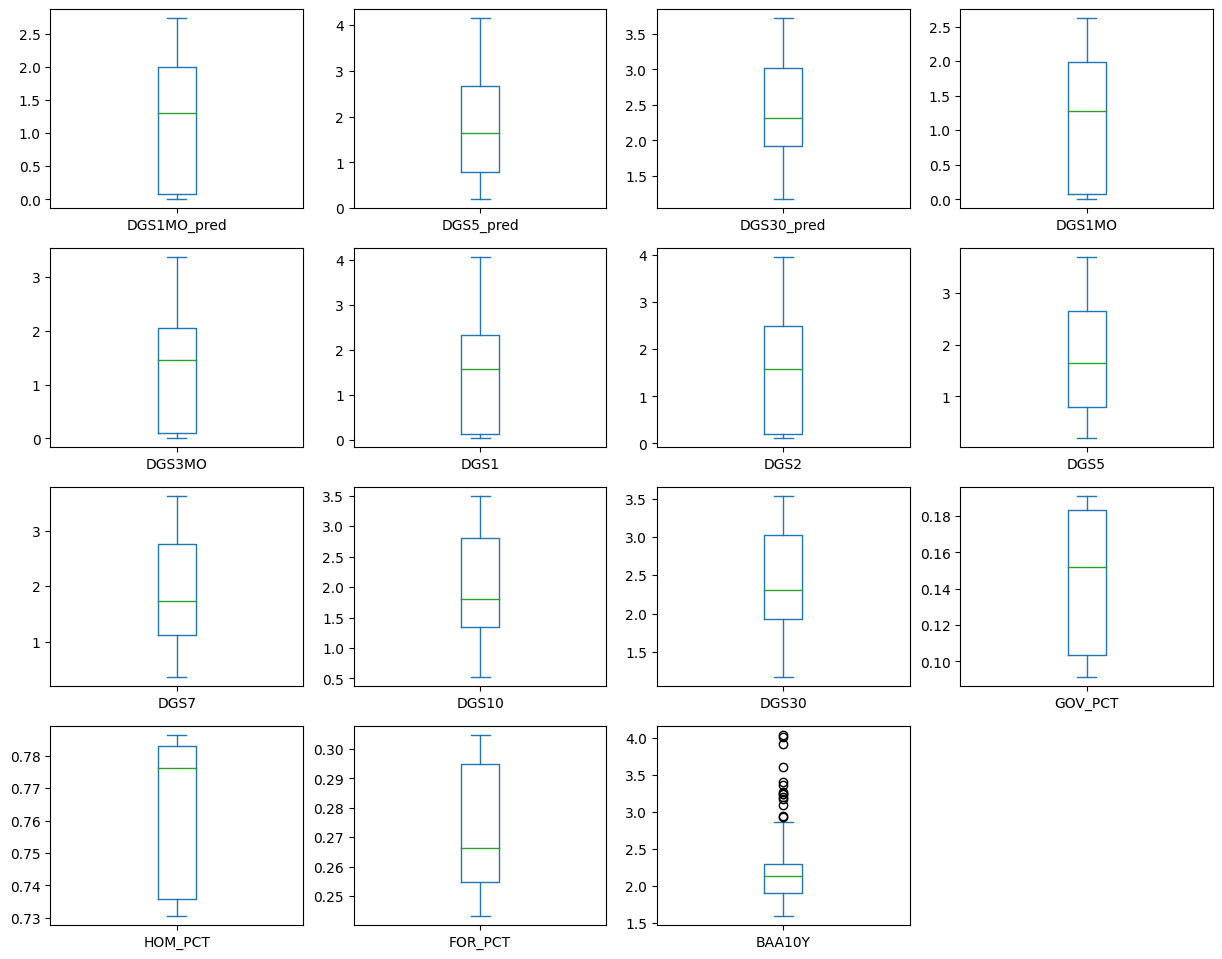

In [11]:
# Box and Whisker Plots

dataset.plot(
    kind='box', 
    subplots=True, 
    layout=(5, 4), 
    sharex=False, 
    sharey=False, 
    figsize=(15, 15)
)
pyplot.show()


Next We look at the interaction between these variables.

<AxesSubplot:title={'center':'Correlation Matrix'}>

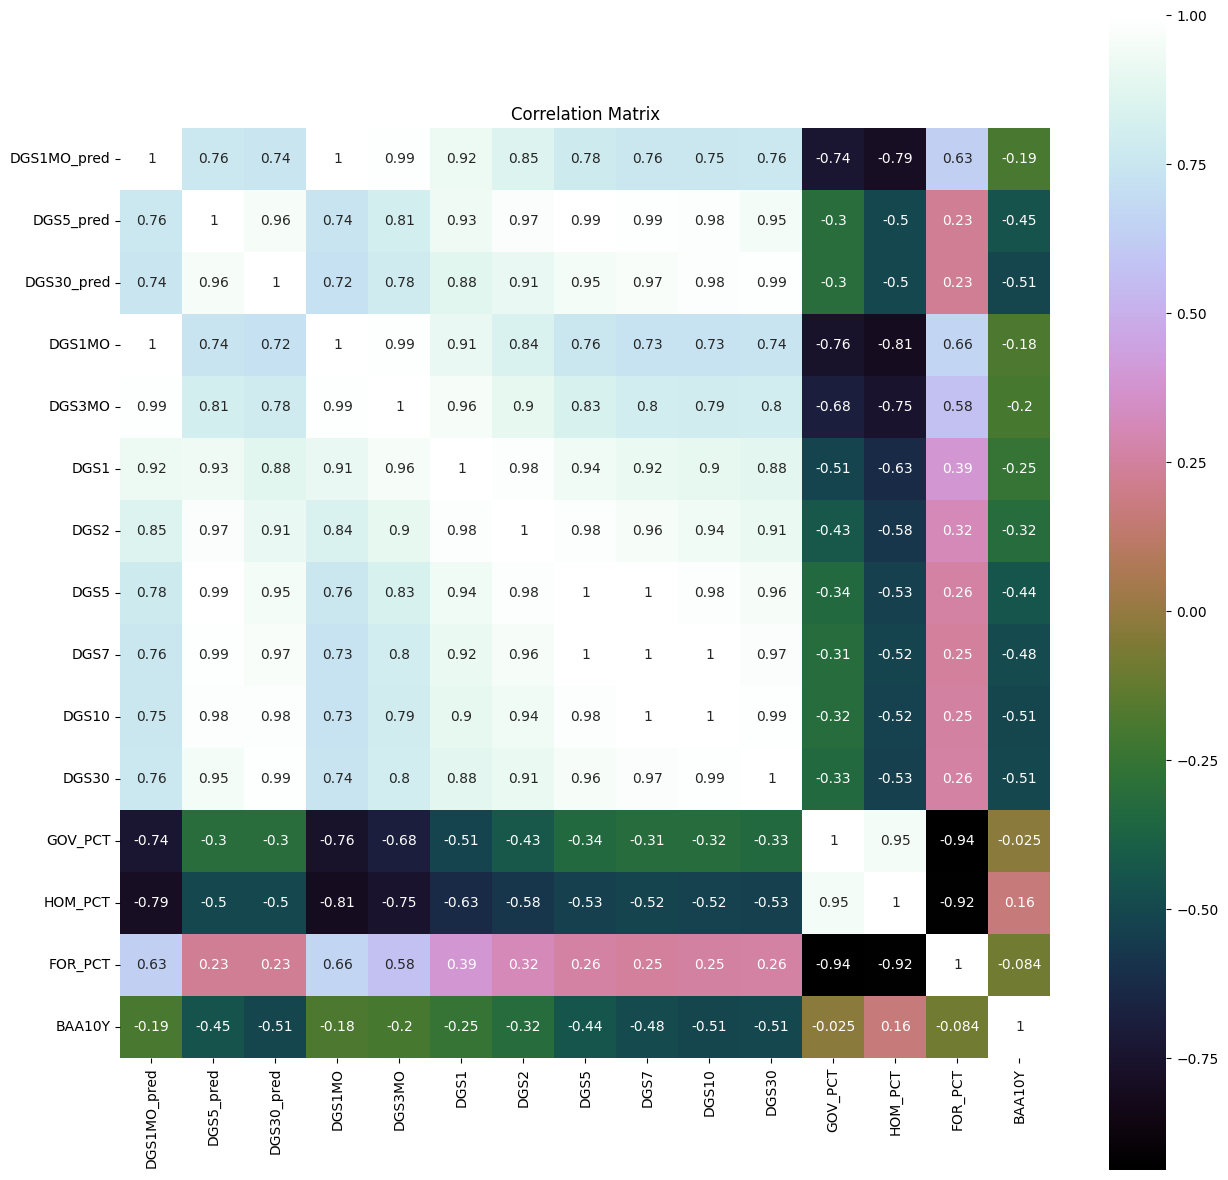

In [12]:
# Correlation

correlation = dataset.corr()
pyplot.figure(figsize=(15, 15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')


Form the correlation plot, we see that the 1 month and the 30 year yield data points are negatively autocorrelated. The 5 year yield also seems toe be negativly correlated with the changes in foreign goverment purchases.

<Figure size 1500x1500 with 0 Axes>

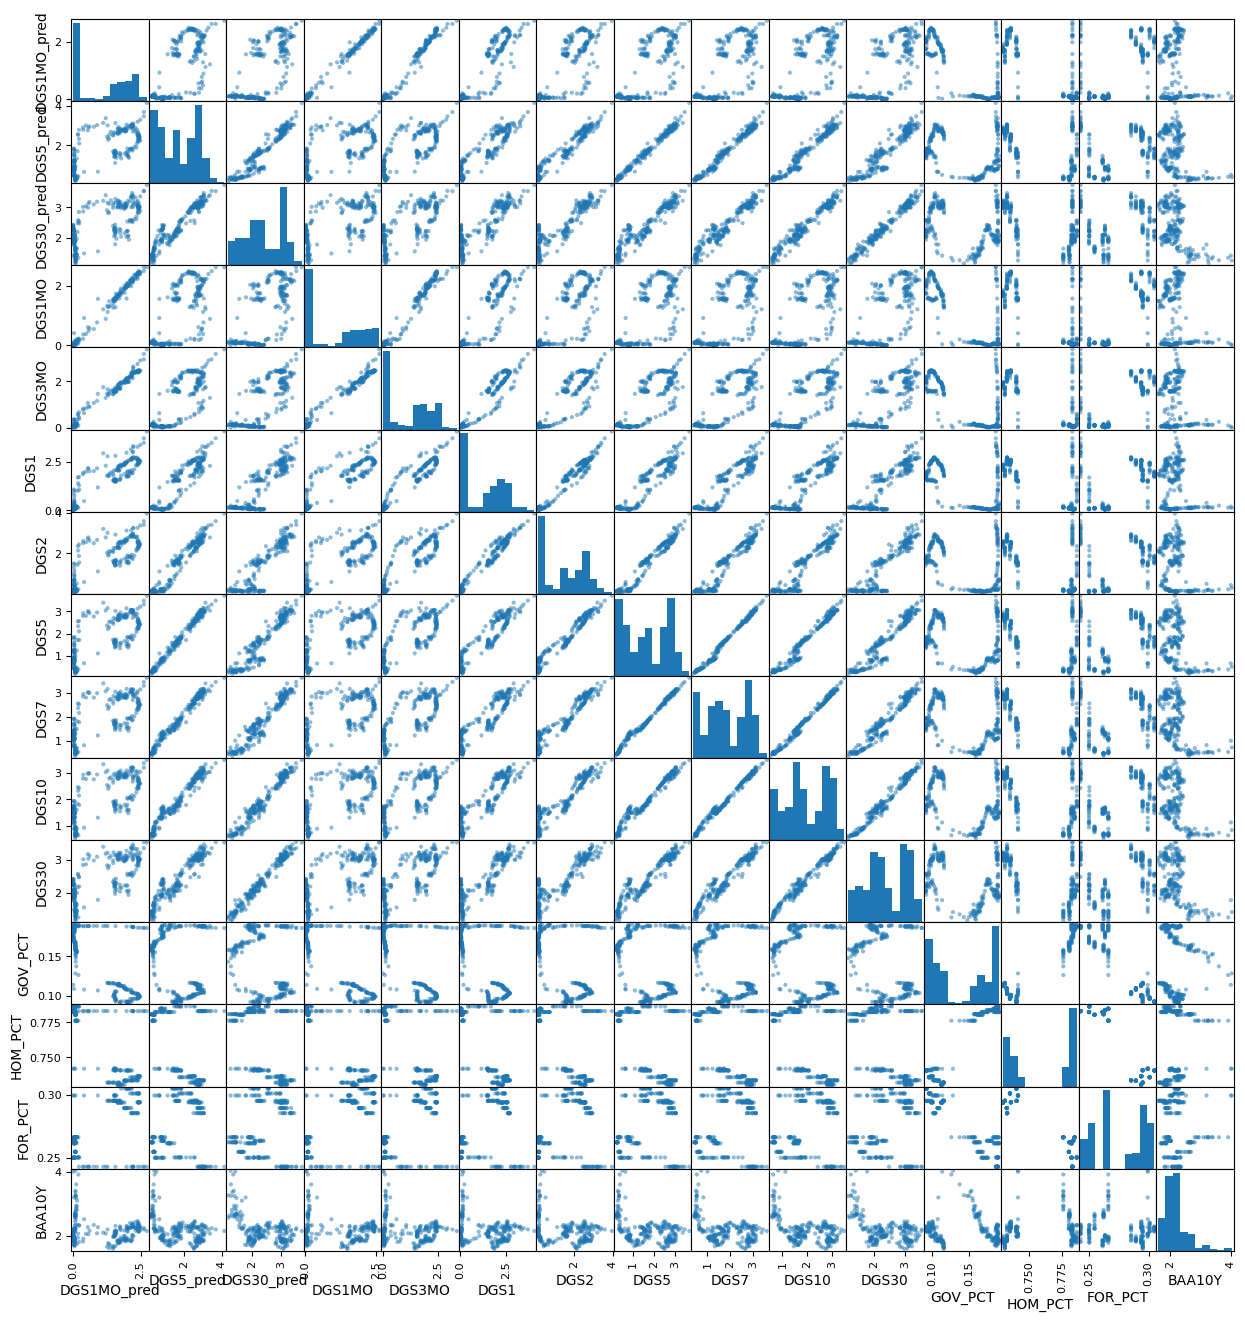

In [13]:
# Scatterplot Matrix

pyplot.figure(figsize=(15,15))
scatter_matrix(dataset, figsize=(15, 16))
pyplot.show()


<a id='2.3'></a>
## 3.3. Time Series Analysis

#### 1 Month

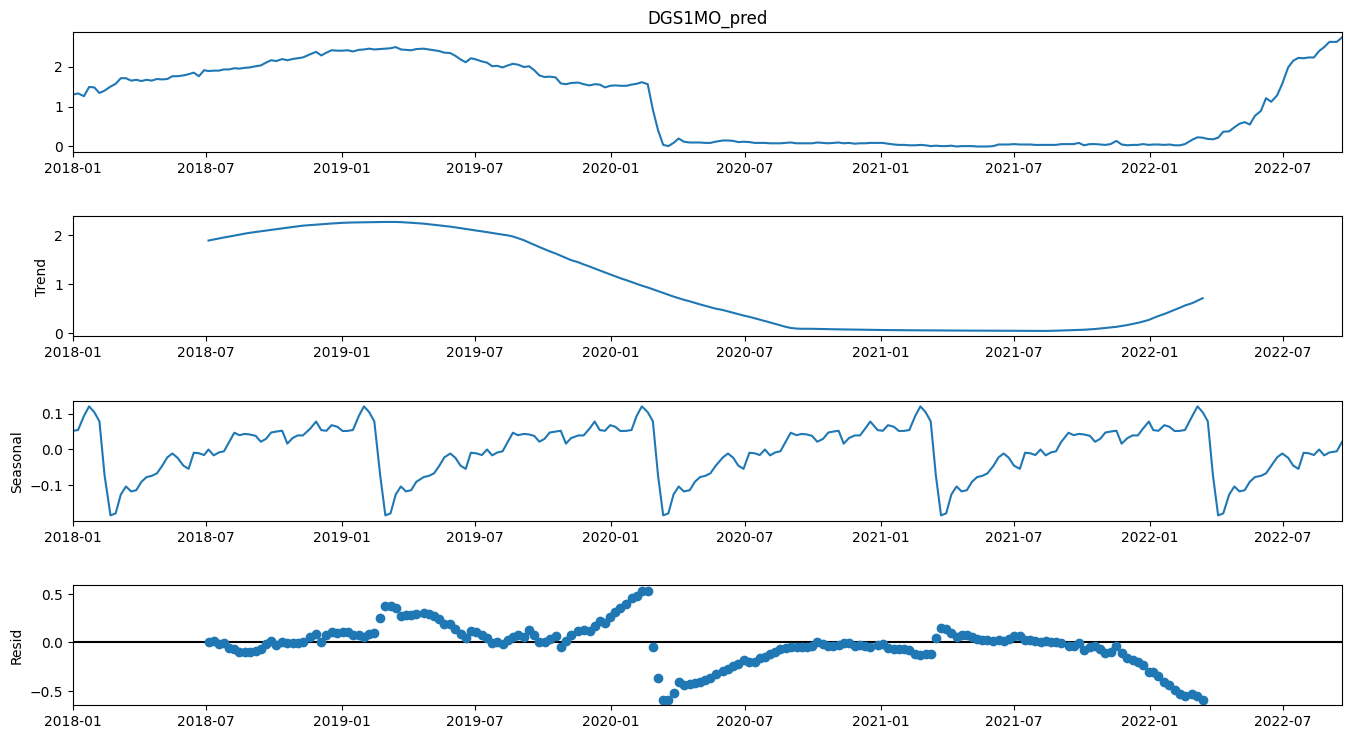

In [14]:
temp_Y = dataset['DGS1MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


#### 5 Year

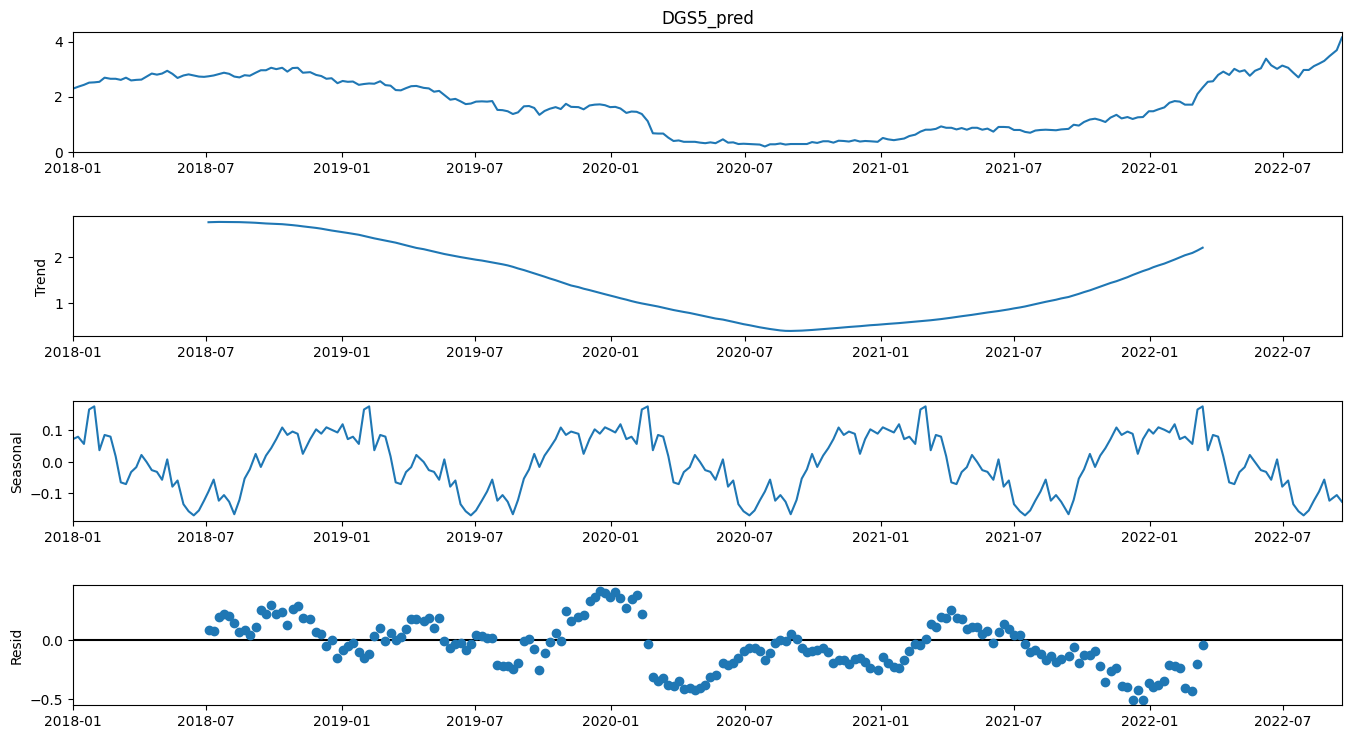

In [15]:
temp_Y = dataset['DGS5_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


#### 30 Year

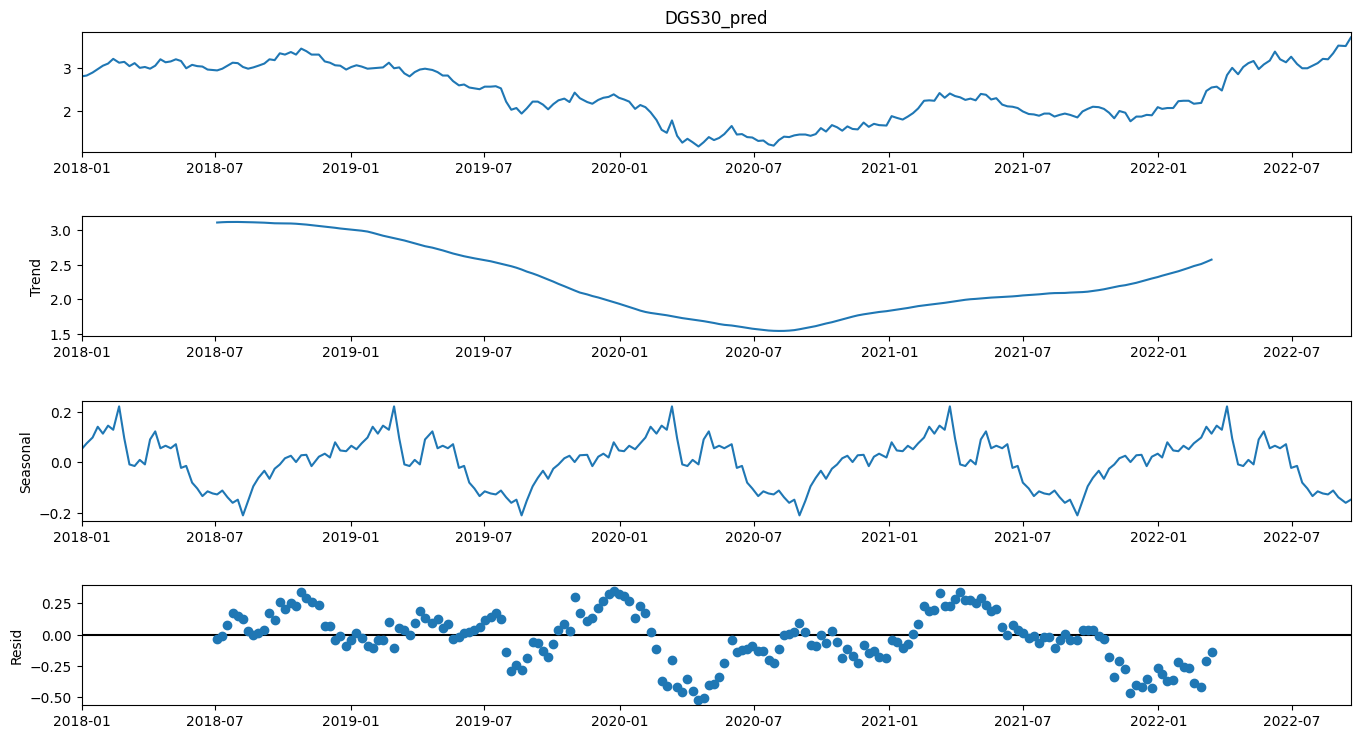

In [16]:
temp_Y = dataset['DGS30_pred']
res = sm.tsa.seasonal_decompose(temp_Y, period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()


Around Q1 2018, we observe a trend decrease in the 1 Month, 5 year and 30 year. However, the trend is most pronounced in the 1 month series.

<a id='3'></a>
## 4. Data Preparation and analysis

<a id='3.1'></a>
## 4.1. Univariate Feature Selection

In [17]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X, temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    
    # Concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']  # Naming the dataframe columns
    print(col)
    print(featureScores.nlargest(10, 'Score'))  # Print 10 best features
    print('--------------')


DGS1MO_pred
     Specs      Score
0   DGS1MO  29053.107
1   DGS3MO  14122.044
2     DGS1   1353.927
3     DGS2    640.434
9  HOM_PCT    388.754
4     DGS5    364.251
7    DGS30    328.517
5     DGS7    316.920
6    DGS10    305.819
8  GOV_PCT    281.123
--------------
DGS5_pred
      Specs      Score
4      DGS5  19746.403
5      DGS7  11339.233
6     DGS10   5149.242
3      DGS2   3796.031
7     DGS30   2089.395
2      DGS1   1461.528
1    DGS3MO    451.540
0    DGS1MO    281.740
9   HOM_PCT     79.433
11   BAA10Y     60.092
--------------
DGS30_pred
      Specs     Score
7     DGS30  8955.789
6     DGS10  5775.043
5      DGS7  3402.880
4      DGS5  2208.427
3      DGS2  1084.553
2      DGS1   781.866
1    DGS3MO   373.449
0    DGS1MO   256.891
11   BAA10Y    84.289
9   HOM_PCT    79.819
--------------


As expected, based on the univariate feature selection, all the time series are most dependent on the previous changes.

<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split and evaluation metrics

In [18]:
# split out validation dataset for the end

validation_size = 0.2

# In this case the data is not dependent on the time series, 
# so we can split the training and testing data randomly
seed = 7
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=validation_size, random_state=seed)


We use the prebuilt scikit models to run a K fold analysis on our training data. We then train the model on the full training data and use it for prediction of the test data. The parameters for the K fold analysis are defined as follows

In [19]:
# Test options for regression

num_folds = 10
scoring = 'neg_mean_squared_error'


<a id='4.2'></a>
## 5.2. Compare Models and Algorithms

In [20]:
models = [
    # Linear models
    ('LR', LinearRegression()),
    ('LASSO', Lasso()),
    ('EN', ElasticNet()),
    ('KNN', KNeighborsRegressor()),
    ('CART', DecisionTreeRegressor()),
    # Neural Network model
    ('MLP', MLPRegressor()),
]

In [21]:
params_kfold_search = ParamsKfold(
    models=models,
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
)
kfold_results = run_kfold_analysis(params_kfold_search)


LR: 0.010207 (0.003177) 0.008245 0.008108
LASSO: 0.755311 (0.111041) 0.743371 0.723997
EN: 0.335539 (0.046664) 0.328940 0.334180
KNN: 0.015888 (0.006286) 0.008871 0.007653
CART: 0.022567 (0.009584) 0.000000 0.012529
MLP: 0.056938 (0.064792) 0.021435 0.021418


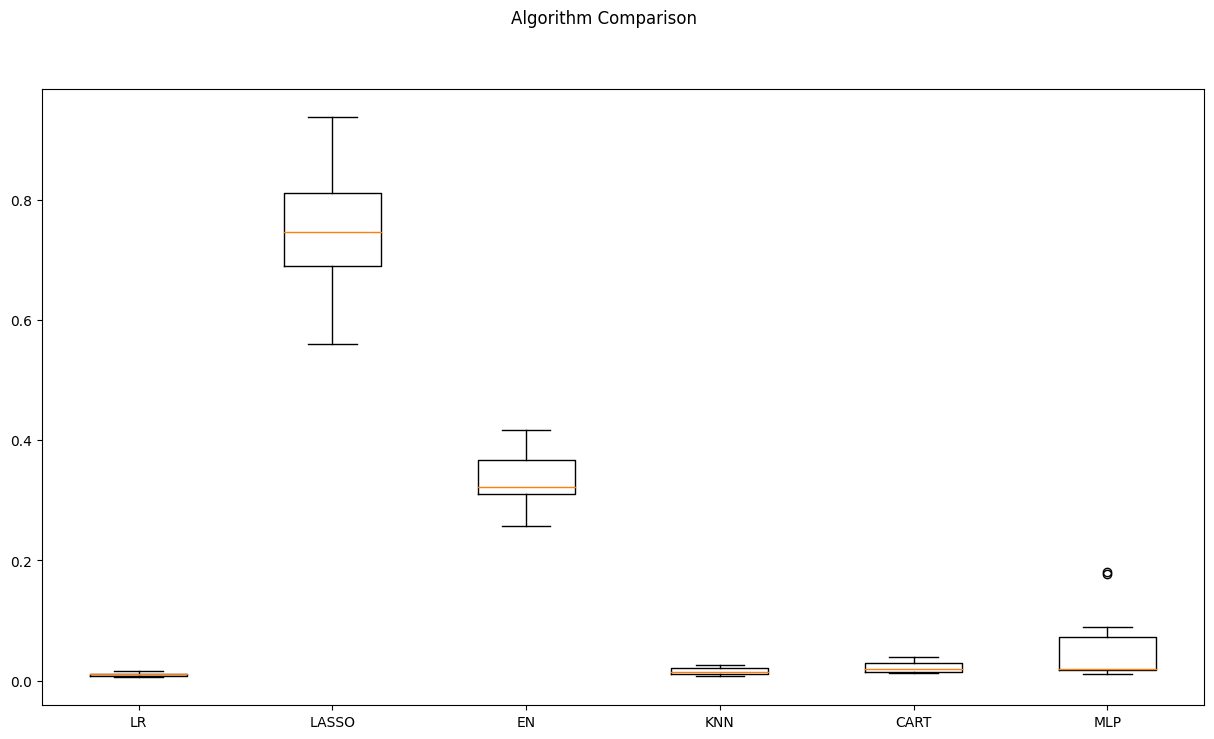

In [22]:
# Compare algorithms

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results.kfold_results)
ax.set_xticklabels(kfold_results.names)
fig.set_size_inches(15, 8)
pyplot.show()


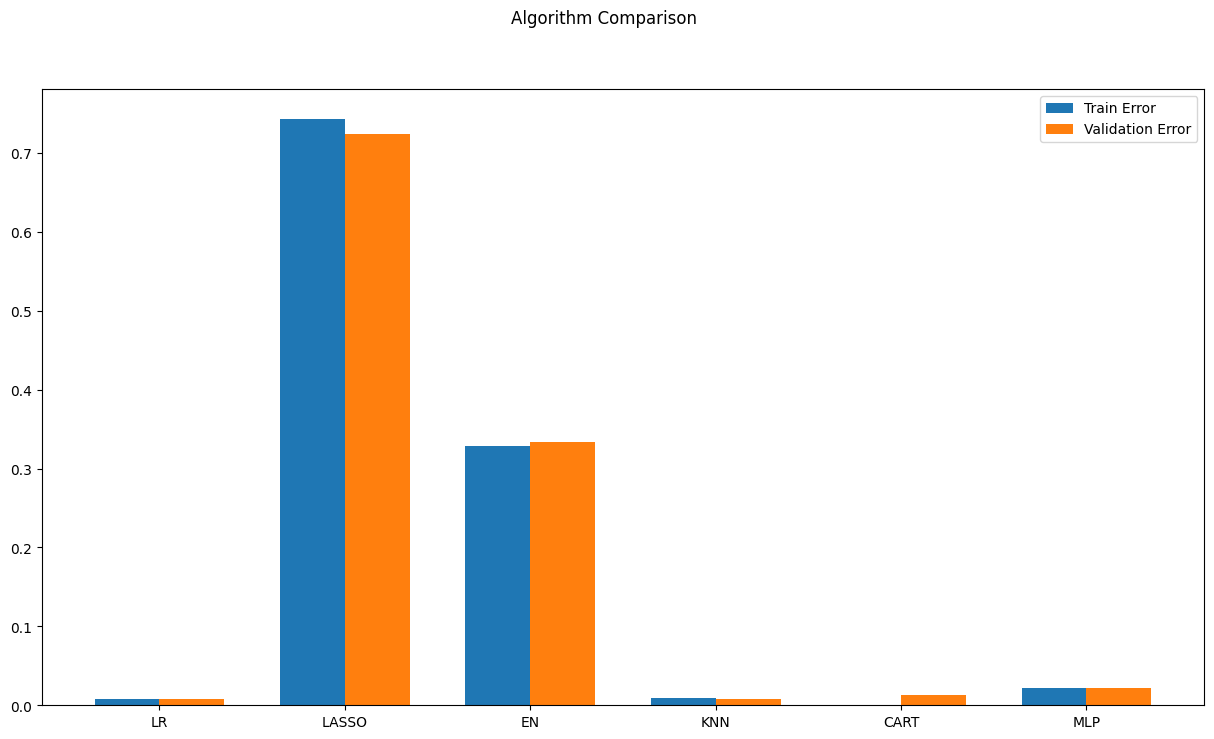

In [23]:
# Compare algorithms again

fig = pyplot.figure()

ind = np.arange(len(kfold_results.names))  # the x locations for the groups
width = 0.35  # the width of the bars

fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - (width / 2), [x.mean() for x in kfold_results.train_results],  width=width, label='Train Error')
pyplot.bar(ind + (width / 2), [x.mean() for x in kfold_results.test_results], width=width, label='Validation Error')
fig.set_size_inches(15, 8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(kfold_results.names)
pyplot.show()


<a id='5'></a>
# 6. Model Tuning and Grid Search

In [24]:
params_search = ParamsGridSearch(
    model=MLPRegressor(),
    params_grid={'hidden_layer_sizes': [(20,), (50,), (20, 20), (20, 30, 20)]},
    X_train=X_train,
    Y_train=Y_train,
    X_test=X_test,
    Y_test=Y_test,
    num_folds=num_folds,
    scoring=scoring,
    seed=seed,
    shuffle=True,

)
search_results = run_grid_search(params_search)


Best: -0.030611 using {'hidden_layer_sizes': (20, 30, 20)}
-0.104507 (0.059594) with: {'hidden_layer_sizes': (20,)}
-0.044589 (0.049317) with: {'hidden_layer_sizes': (50,)}
-0.058393 (0.055390) with: {'hidden_layer_sizes': (20, 20)}
-0.030611 (0.027173) with: {'hidden_layer_sizes': (20, 30, 20)}


<a id='6'></a>
# 7. Finalise the Model

In [25]:
# Prepare model

model = MLPRegressor(hidden_layer_sizes=search_results.best_params_['hidden_layer_sizes'])
model.fit(X_train, Y_train)


MLPRegressor(hidden_layer_sizes=(20, 30, 20))

<a id='6.1'></a>
## 7.1. Results and comparison of Regression and MLP

In [26]:
# Estimate accuracy on validation set

predictions = model.predict(X_test)
mse_MLP = mean_squared_error(Y_test, predictions)
r2_MLP = r2_score(Y_test, predictions)

# Prepare model

model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_test)

mse_OLS = mean_squared_error(Y_test, predictions_2)
r2_OLS = r2_score(Y_test, predictions_2)
print(f"MSE Regression = {mse_OLS:.6f}, MSE MLP = {mse_MLP:.6f}")
print(f"R2 Regression = {r2_OLS:.6f}, R2 MLP = {r2_MLP:.6f}")


MSE Regression = 0.008108, MSE MLP = 0.020011
R2 Regression = 0.985893, R2 MLP = 0.963342


The statistics of MLP and Linear regression are comparable. Let us check the prediction shape on the validation set. 

### Predictions - 5 Year - MLP

In [27]:
train_size = int(len(X) * (1 - validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes=(50,))
modelOLS = LinearRegression()
model_MLP = modelMLP.fit(X_train, Y_train)
model_OLS = modelOLS.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(
    model_MLP.predict(X_test), 
    index=Y_test.index,
    columns=Y_test.columns
)
Y_predOLS = pd.DataFrame(
    model_OLS.predict(X_test), 
    index=Y_test.index,
    columns=Y_test.columns
)


<AxesSubplot:xlabel='DATE'>

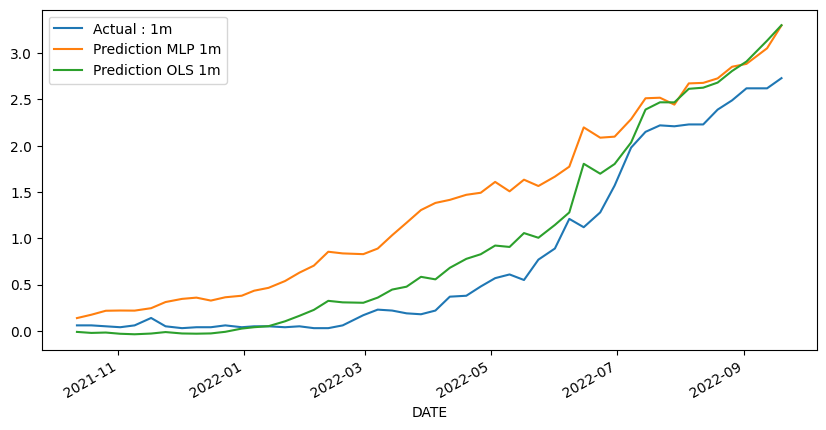

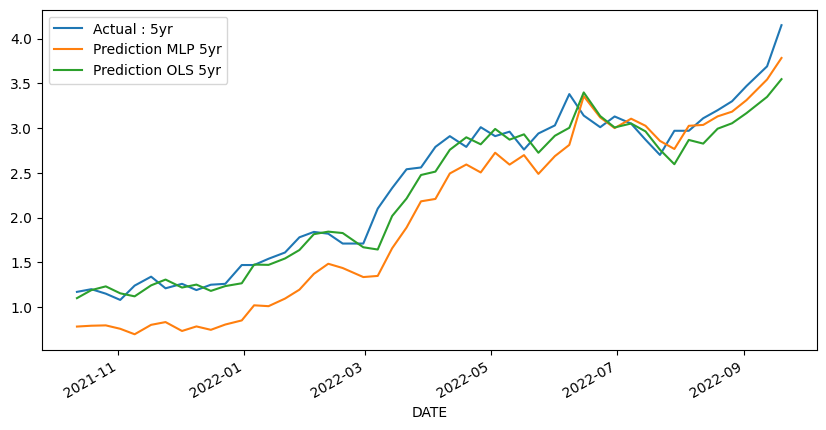

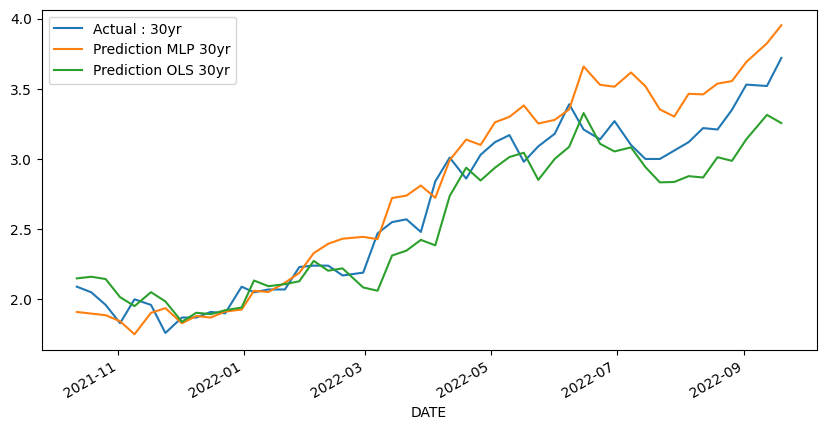

In [28]:
# Plot predictions

(
    pd
    .DataFrame({
        'Actual : 1m': Y_test.loc[:, 'DGS1MO_pred'],
        'Prediction MLP 1m': Y_predMLP.loc[:, 'DGS1MO_pred'],
        'Prediction OLS 1m': Y_predOLS.loc[:, 'DGS1MO_pred']
    })
    .plot(figsize=(10, 5))
)
(
    pd
    .DataFrame({
        'Actual : 5yr': Y_test.loc[:, 'DGS5_pred'],
        'Prediction MLP 5yr': Y_predMLP.loc[:, 'DGS5_pred'],
        'Prediction OLS 5yr': Y_predOLS.loc[:, 'DGS5_pred']
    })
    .plot(figsize=(10, 5))

)
(
    pd
    .DataFrame({
        'Actual : 30yr': Y_test.loc[:, 'DGS30_pred'],
        'Prediction MLP 30yr': Y_predMLP.loc[:, 'DGS30_pred'],
        'Prediction OLS 30yr': Y_predOLS.loc[:, 'DGS30_pred']
    })
    .plot(figsize=(10, 5))
)


Overall, the regression and MLP are comparable, however, for 1m tenor, the fitting with MLP is slighly poor as compared to the regression. However,the multitask learning with neural network is more intuitive for modeling many time series simultaneousl 

### Summary

The linear regression model, despite its simplicity, is a tough benchmark to beat for such one step ahead forecasting, given the dominant characteristic of the last available value of the variable to predict. The ANN results in this case study are comparable to the linear regression models.

The good thing about ANN is that it is more flexible to changing market conditions. Also, ANN models can be enhanced by performing grid search on several other hyperparameters and using recurrent neural network such as LSTM.